In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

import random
import glob
import wandb
from wandb.keras import WandbCallback
import subprocess
import os

from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, UpSampling2D
from keras import backend as K

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, concatenate
from keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Add
from keras.models import Model

In [2]:
#initialize wandb

hyperparams = {"num_epochs": 10, 
          "batch_size": 32,
          "height": 96,
          "width": 96}

wandb.init(config=hyperparams)
config = wandb.config

val_dir = 'catz/val'
train_dir = 'catz/train'
test_dir = 'catz/test'

wandb: Currently logged in as: dskk (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
# generator to loop over train, test and test images

def data_generator(batch_size, img_dir):
    """
    This is data generator that generates'batch_size' inputs. 
    An input is 5 images with the frame to be predicted.
    Returns 5 images plus a result image"""
    
    cat_dirs = glob.glob(img_dir + "/*")
    counter = 0
    while True:
        input_images = np.zeros(
            (batch_size, config.width, config.height, 3 * 5))
        output_images = np.zeros((batch_size, config.width, config.height, 3))
        random.shuffle(cat_dirs)
        if (counter+batch_size >= len(cat_dirs)):
            counter = 0
        for i in range(batch_size):
            input_imgs = glob.glob(cat_dirs[counter + i] + "/cat_[0-5]*")
            imgs = [Image.open(img) for img in sorted(input_imgs)]
            input_images[i] = np.concatenate(imgs, axis=2)
            output_images[i] = np.array(Image.open(
                cat_dirs[counter + i] + "/cat_result.jpg"))
            input_images[i] /= 255.
            output_images[i] /= 255.
        yield (input_images, output_images)
        counter += batch_size
        
steps_per_epoch = len(glob.glob(train_dir + "/*")) // config.batch_size
validation_steps = len(glob.glob(val_dir + "/*")) // config.batch_size

In [4]:
#callback to log the images

class ImageCallback(Callback):
    
    def on_epoch_end(self, epoch, logs):
        validation_X, validation_y = next(data_generator(15, val_dir))
        output = self.model.predict(validation_X)
        wandb.log({
            "input": [wandb.Image(np.concatenate(np.split(c, 5, axis=2), axis=1)) for c in validation_X],
            "output": [wandb.Image(np.concatenate([validation_y[i], pred], axis=1)) for i, pred in enumerate(output)]
        }, commit=False)

# Data Analysis

In [97]:
no_of_train_images = len(os.listdir(train_dir))
no_of_val_images = len(os.listdir(val_dir))
no_of_test_images = len(os.listdir(test_dir))
total_images = no_of_val_images+no_of_train_images+no_of_test_images
print("Total no of images available in the dataset:",total_images)

Total no of images available in the dataset 7890


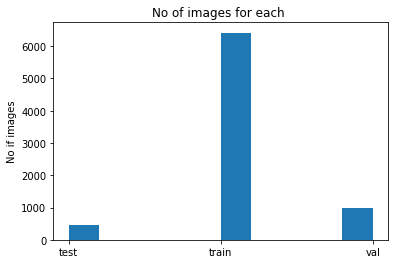

No of Training Images: 6418
No of Validation Images: 1000
No of Test Images: 472


In [98]:
images_count = []
for j, file in enumerate(os.listdir('catz')):
    for i in os.listdir('catz\\'+file):
        
        if(j==0):
            images_count.append('test')
        if(j==1):
            images_count.append('train')
        if(j==2):
            images_count.append('val')
            
plt.hist(images_count)

plt.ylabel('No if images')
plt.title('No of images for each ')
plt.show()

print("No of Training Images:", no_of_train_images)
print("No of Validation Images:", no_of_val_images)
print("No of Test Images:", no_of_test_images)

In [5]:
# Test the generator
gen = data_generator(5, train_dir)
videos, next_frame = next(gen)
videos[1].shape, next_frame[1].shape

((96, 96, 15), (96, 96, 3))

As we can see, the generator generates 5 images concatenated and the next image in the sequence

Let's make a video with the images returned by data_generator

MovieWriter ffmpeg unavailable; using Pillow instead.


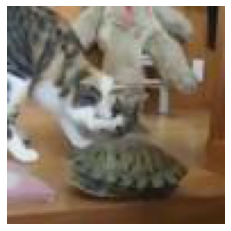

In [6]:
img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
plt.axis('off')
for i in range(0, 13, 3):
#     print(i, i+3)
    frames.append([plt.imshow(videos[0][:,:,i:i+3], animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True,
                                repeat_delay=1000)
ani.save('movie.gif')
plt.show()

This is the video without last frame. ( Consider as input to our model )

MovieWriter ffmpeg unavailable; using Pillow instead.


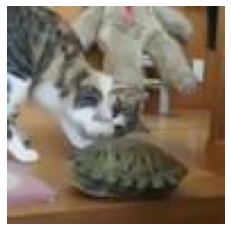

In [7]:
frames = [] # for storing the generated images
fig = plt.figure()
plt.axis('off')
for i in range(0, 13, 3):
    frames.append([plt.imshow(videos[0][:,:,i:i+3], animated=True)])
frames.append([plt.imshow(next_frame[0], animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True,
                                repeat_delay=1000)
ani.save('predicted.gif')
plt.show()

This is the video with predicted frame, and this has to be our desired output.

#### Note: The videos are saved in the current directory as gif files. ( 'movie.gif' and 'predicted.gif' ) 
The frame rate is kept slow intentionally to identify changes occuring for every frame.


In [8]:
# Function for measuring how similar two images are
def perceptual_distance(y_true, y_pred):
    y_true *= 255.
    y_pred *= 255.
    rmean = (y_true[:, :, :, 0] + y_pred[:, :, :, 0]) / 2
    r = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    g = y_true[:, :, :, 1] - y_pred[:, :, :, 1]
    b = y_true[:, :, :, 2] - y_pred[:, :, :, 2]

    return K.mean(K.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)))

# Building the Model

In [106]:
def slice(x):
    return x[:,:,:,:, -1]

c=4

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)

last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(permuted)
x = Permute((4,1,2,3))(permuted)

x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='ConvLstm1', return_sequences=True))(x)

c1=(BatchNormalization())(x)
x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c1)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='ConvLstm2',return_sequences=True))(x)
c2=(BatchNormalization())(x)

x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c2)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='ConvLstm3',return_sequences=True))(x)
c3 =(BatchNormalization())(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(c3)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='ConvLstm4',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='ConvLstm5',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='ConvLstm6',return_sequences=False))(x)
x =(BatchNormalization())(x)

combined = concatenate([last_layer, x])
combined = Conv2D(3, (1,1))(combined)
model1=Model(inputs=[inp], outputs=[combined])

model1.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])
model1.summary()

Model: "functional_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 15)] 0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 96, 96, 5, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
permute_6 (Permute)             (None, 96, 96, 3, 5) 0           reshape_3[0][0]                  
__________________________________________________________________________________________________
permute_7 (Permute)             (None, 5, 96, 96, 3) 0           permute_6[0][0]                  
_______________________________________________________________________________________

In [107]:
%wandb

wandb.init(config=hyperparams)
config = wandb.config

model1.fit(data_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=data_generator(config.batch_size, val_dir))

wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
50/50 [==============================] - 317s 6s/step - loss: 0.9932 - perceptual_distance: 721.1459 - val_loss: 0.7682 - val_perceptual_distance: 564.1472
Epoch 2/10
50/50 [==============================] - 316s 6s/step - loss: 0.5695 - perceptual_distance: 551.6410 - val_loss: 0.6450 - val_perceptual_distance: 511.3966
Epoch 3/10
50/50 [==============================] - 317s 6s/step - loss: 0.3848 - perceptual_distance: 445.2125 - val_loss: 0.4572 - val_perceptual_distance: 423.2618
Epoch 4/10
50/50 [==============================] - 316s 6s/step - loss: 0.2494 - perceptual_distance: 353.5336 - val_loss: 0.3420 - val_perceptual_distance: 365.9878
Epoch 5/10
50/50 [==============================] - 312s 6s/step - loss: 0.1600 - perceptual_distance: 277.5150 - val_loss: 0.2427 - val_perceptual_distance: 306.5153
Epoch 6/10
50/50 [==============================] - 313s 6s/step - loss: 0.1025 - perceptual_distance: 219.1981 - val_loss: 0.1860 - val_perceptual_distance: 267.163

wandb: Network error resolved after 0:01:20.549554, resuming normal operation.
wandb: Network error resolved after 0:01:10.221732, resuming normal operation.


# A Better Model

In [9]:
def slice(x):
    return x[:,:,:,:, -1]

c=4

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)

# Adding gaussian noise to the training images makes it less baised and performs better on test and validation data
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
x = Permute((4,1,2,3))(noise)

x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='ConvLstm1', return_sequences=True))(x)

c1=(BatchNormalization())(x)
x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c1)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='ConvLstm2',return_sequences=True))(x)
c2=(BatchNormalization())(x)

x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c2)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='ConvLstm3',return_sequences=True))(x)
c3 =(BatchNormalization())(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(c3)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='ConvLstm4',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='ConvLstm5',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='ConvLstm6',return_sequences=False))(x)
x =(BatchNormalization())(x)

combined = concatenate([last_layer, x])
combined = Conv2D(3, (1,1))(combined)
model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 15)] 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 96, 5, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 96, 96, 3, 5) 0           reshape[0][0]                    
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 96, 96, 3, 5) 0           permute[0][0]                    
_______________________________________________________________________________________

# Training the model

In [10]:
%wandb

wandb.init(config=hyperparams)
config = wandb.config

model.fit(data_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=data_generator(config.batch_size, val_dir))

wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
50/50 [==============================] - 325s 6s/step - loss: 0.3782 - perceptual_distance: 386.8341 - val_loss: 0.2315 - val_perceptual_distance: 288.2466
Epoch 2/10
50/50 [==============================] - 316s 6s/step - loss: 0.1754 - perceptual_distance: 271.0931 - val_loss: 0.1380 - val_perceptual_distance: 230.3666
Epoch 3/10
50/50 [==============================] - 314s 6s/step - loss: 0.1091 - perceptual_distance: 214.2604 - val_loss: 0.0684 - val_perceptual_distance: 168.7642
Epoch 4/10
50/50 [==============================] - 312s 6s/step - loss: 0.0716 - perceptual_distance: 173.6301 - val_loss: 0.0371 - val_perceptual_distance: 129.1250
Epoch 5/10
50/50 [==============================] - 311s 6s/step - loss: 0.0475 - perceptual_distance: 141.5240 - val_loss: 0.0308 - val_perceptual_distance: 120.2841
Epoch 6/10
50/50 [==============================] - 324s 6s/step - loss: 0.0320 - perceptual_distance: 115.3031 - val_loss: 0.0241 - val_perceptual_distance: 104.113

# Test the Model

In [102]:
%%time
X_test, actual_frames = next(data_generator(472, test_dir))
predicted_frames = model.predict(X_test)

Wall time: 22.1 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


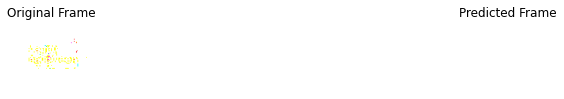

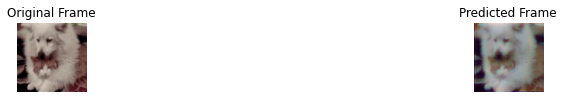

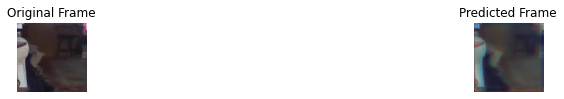

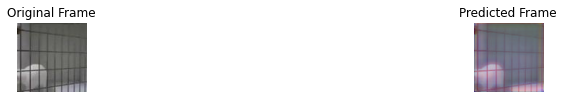

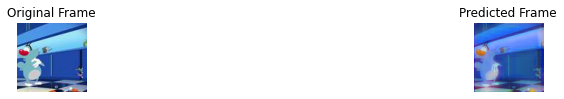

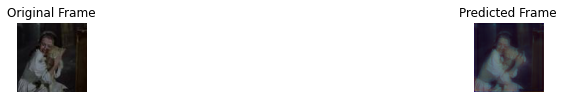

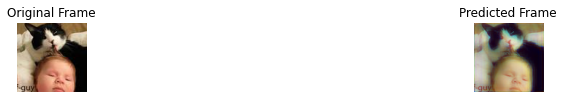

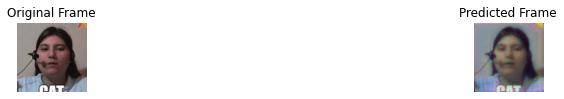

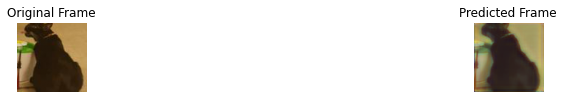

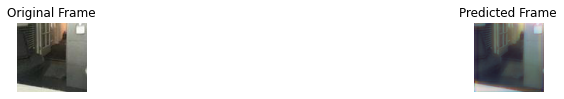

In [36]:
for i in range(10):
    
    #Plot input sequence
#     plt.figure(figsize=(15,15))
#     ax = plt.subplot(10,3,i*2+1)
#     input_seq = [np.concatenate(np.split(c, 5, axis=2), axis=1) for c in X_test[i]]
#     plt.imshow(input_seq)
#     plt.title('Input Image Sequence')
#     plt.axis('off')
    
    # Plot Original Frame
    plt.figure(figsize=(15,15))
    ax = plt.subplot(10,2,i*2+1)
    plt.imshow(actual_frames[i])
    plt.title('Original Frame')
    plt.axis('off')
    
    # Plot Predicted Frame
    ax = plt.subplot(10,2,i*2+2)
    plt.imshow(predicted_frames[i])
    plt.title('Predicted Frame')
    #plt.xlabel('Perceptual Distance:',perceptual_distance(actual_frames[i], predicted_frames[i]))
    plt.axis('off')

As we can see here, the features of next frame are predicted with a great accuracy.

In [16]:
print("The model has predicted 472 frames based on 5 input frames in 18.9 seconds")
print(f"Hence the model can predict {int(472/20.2)} frames in 1 second")

The model has predicted 472 frames based on 5 input frames in 18.9 seconds
Hence the model can predict 23 frames in 1 second
